In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as spalg
import scipy.ndimage as ndimage
import scipy.stats as stats
import skimage.transform
from tqdm import tqdm, trange

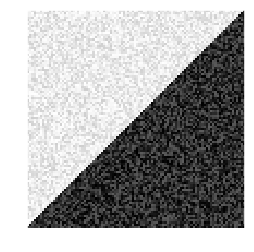

In [2]:
def step_image_BW(n=100):
    ref_img = 0.7 + 0.3 * np.random.uniform(size=(n, n))
    ref_img[np.tril_indices_from(ref_img)] -= 0.7
    ref_img = (ref_img * 255)[:, :, None].astype(int)
    return ndimage.rotate(ref_img, 90)

plt.imshow(step_image_BW()[:, :, 0], cmap="Greys_r")

In [3]:
def get_coord_from_vertex_example(v, W, X, Y, Z):
    w = (v // (Z * Y * X)) % W
    x = (v // (Z * Y)) % X
    y = (v // (Z)) % Y
    z = v % Z
    return w, x, y, z

def get_coord_from_vertex_expensive(v, grid_shape):
    return [
        np.indices(grid_shape)[i].flatten()[v]
        for i in range(len(grid_shape))
    ]

def get_coord_from_vertex(v, grid_shape):
    v = np.array(v)
    grid_shape = np.array(grid_shape)
    prod = np.cumprod(grid_shape[::-1])[::-1][1:][:, None]
    first_coord = (v // prod) % grid_shape[:-1][:, None]
    last_coord = v % grid_shape[-1]
    return np.vstack([first_coord, last_coord]).T

def get_vertex_from_coord_example(w, x, y, z, W, X, Y, Z):
    return (
        (Z * Y * X) * w +
        (Z * Y) * x +
        (Z) * y *
        z
    )

def get_vertex_from_coord(coord, grid_shape):
    coord = np.array(coord)
    grid_shape = np.array(grid_shape)
    prod = np.cumprod(grid_shape[::-1])[::-1][1:][:, None]
    return (coord[:, :-1].dot(prod) + coord[:, -1:])[:, 0]

In [24]:
class BilateralGrid:
    
    def __init__(self, ref_img, sigma):
        self.ref_img = ref_img
        self.sigma = sigma
        
        self.compute_everything()
        
    def compute_everything(self):
        self.compute_useful_stuff()
        self.compute_splat()
        self.compute_blur()
        self.compute_bistochastization()
        self.compute_pyramid_space()
        
    def compute_useful_stuff(self):
        
        self.D = 2 + self.ref_img.shape[2]
        
        self.grid_shape = np.hstack([
            np.ceil(self.ref_img.shape[:2] / self.sigma[:2]) + 1,
            np.ceil(self.ref_img.max() / self.sigma[2:]) + 1
        ]).astype(int)
        
        self.n_pixels = np.prod(self.ref_img.shape[:2])
        self.n_vertices = np.prod(self.grid_shape)
        
        self.x_ref_img = np.indices(self.ref_img.shape[:2])[0].flatten()
        self.y_ref_img = np.indices(self.ref_img.shape[:2])[1].flatten()
        
        self.pos_ref_img = np.hstack([
            self.x_ref_img[:, None],
            self.y_ref_img[:, None],
            self.ref_img[self.x_ref_img, self.y_ref_img]
        ])
        
    def compute_splat(self):
        
        tqdm(desc="Splat matrix computation")
        
        self.pos_grid = np.rint(self.pos_ref_img / self.sigma).astype(int)
        
        self.nearest_neighbors = get_vertex_from_coord(self.pos_grid, self.grid_shape)
                
        self.useful_vertices = np.sort(np.unique(self.nearest_neighbors))
        self.n_useful_vertices = len(self.useful_vertices)
        
        self.useful_vertex_to_coord = get_coord_from_vertex(self.useful_vertices, self.grid_shape)
    
        self.useful_vertex_to_ind = np.empty(self.n_vertices)
        self.useful_vertex_to_ind[self.useful_vertices] = np.arange(self.n_useful_vertices)
        self.vertex_is_useful = np.zeros(self.n_vertices)
        self.vertex_is_useful[self.useful_vertices] = 1
        
        S = sparse.lil_matrix((self.n_useful_vertices, self.n_pixels), dtype=np.float)
        S[self.useful_vertex_to_ind[self.nearest_neighbors], np.arange(self.n_pixels)] = 1     
        self.S = S.tocsr()
        
    def compute_blur(self):
        
        B = sparse.lil_matrix((self.n_useful_vertices, self.n_useful_vertices), dtype=np.float)
        B[np.diag_indices_from(B)] = 6

        possible_neighbor_steps = [
            np.array([0] * dim + [1] + [0] * (self.D - dim - 1))
            for dim in range(self.D)
        ] + [
            np.array([0] * dim + [-1] + [0] * (self.D - dim - 1))
            for dim in range(self.D)
        ]

        for neighbor_step in tqdm(possible_neighbor_steps, desc="Blur matrix computation"):
                        
            neighbors_coord = self.useful_vertex_to_coord + neighbor_step
            
            neighbors_exist = True
            for dim, dim_size in enumerate(self.grid_shape):
                neighbors_exist = (
                    neighbors_exist &
                    (neighbors_coord[:, dim] >= 0) &
                    (neighbors_coord[:, dim] < dim_size)
                )
            
            vertices_with_existing_neighbors = self.useful_vertices[neighbors_exist]
            existing_neighbors_coord = neighbors_coord[neighbors_exist]
            existing_neighbors_vertices = get_vertex_from_coord(existing_neighbors_coord, self.grid_shape)
            
            neighbors_among_useful = self.vertex_is_useful[existing_neighbors_vertices].astype(bool)
            vertices_with_useful_neighbors = vertices_with_existing_neighbors[neighbors_among_useful]
            useful_neighbors_vertices = existing_neighbors_vertices[neighbors_among_useful]
            
            B[
                self.useful_vertex_to_ind[vertices_with_useful_neighbors],
                self.useful_vertex_to_ind[useful_neighbors_vertices]
            ] = 1

        self.B = B.tocsr()
        
    def compute_bistochastization(self):
        self.Dn, self.Dm = bistochastize(self.S, self.B)
        
    def compute_pyramid_space(self):
        self.S_pyr = build_pyramid(self.useful_vertex_to_coord)
        self.P = build_P(self.S_pyr)
        self.z_weight_init = build_z_weight(self.S_pyr, alpha=4, beta=0)
        self.z_weight_precond = build_z_weight(self.S_pyr, alpha=2, beta=5)

In [25]:
def bistochastize(S, B, iterations=20):
    tqdm(desc="Bistochastization")
    m = S.dot(np.ones(S.shape[1]))
    n = np.ones(B.shape[1])
    for it in range(iterations):
        new_n = np.sqrt((n * m) / (B.dot(n)))
        if np.linalg.norm(new_n - n) < 1e-5:
            break
        else:
            n = new_n
    Dn = sparse.diags(n)
    Dm = sparse.diags(m)
    return Dn, Dm

In [26]:
def prec_conj_grad(A, b, init, M_1, iterations=25):
    x = init
    r = b - A.dot(x)
    d = M_1(r)
    delta_new = r.dot(d)
    for it in range(iterations):
        q = A.dot(d)
        alpha = delta_new / d.dot(q)
        x = x + alpha * d
        r = r - alpha * q
        s = M_1(r)
        delta_old = delta_new
        delta_new = r.dot(s)
        beta = delta_new / delta_old
        d = s + beta * d
    return x

In [27]:
def bilateral_representation(V, sigma):
    D = V.shape[1]
    grid_shape = np.ceil((V.max(axis=0) / sigma) + 1).astype(int)
    
    n_abstract_pixels = len(V)
    n_vertices = np.prod(grid_shape)
    
    pos_grid = np.rint(V / sigma).astype(int)

    nearest_neighbors = get_vertex_from_coord(pos_grid, grid_shape)
    useful_vertices = np.sort(np.unique(nearest_neighbors))
    n_useful_vertices = len(useful_vertices)
    
    useful_vertex_to_ind = np.empty(n_vertices)
    useful_vertex_to_ind[useful_vertices] = np.arange(n_useful_vertices)
    
    S = sparse.lil_matrix((n_useful_vertices, n_abstract_pixels), dtype=np.float)
    S[useful_vertex_to_ind[nearest_neighbors], np.arange(n_abstract_pixels)] = 1
    S = S.tocsr()
        
    new_V = get_coord_from_vertex(useful_vertices, grid_shape)
        
    return S, new_V

In [28]:
def build_pyramid(useful_vertex_to_coord):
    tqdm(desc="Pyramid space construction")
    V = useful_vertex_to_coord
    S_pyr = []
    while len(V) > 1:
        Sk, V = bilateral_representation(V, 2 * np.ones(V.shape[1]))
        S_pyr.append(Sk)
    return S_pyr

def build_P(S_pyr):
    prod = sparse.eye(S_pyr[0].shape[1])
    P = prod
    for s in S_pyr:
        prod = s.dot(prod)
        P = sparse.vstack([P, prod])
    return P

def build_z_weight(S_pyr, alpha, beta):
    z_weight = np.ones(S_pyr[0].shape[1])
    for k, s in enumerate(S_pyr):
        z_weight = np.hstack([
            z_weight,
            (alpha ** (- beta - k - 1)) * np.ones(s.shape[0])
        ])
    return z_weight

In [29]:
def M_jacobi(y, A):
    return y / A.diagonal()

def M_hier(y, A, P, z_weight):
    z_size, y_size = P.shape
    
    P1 = P.dot(np.ones(y_size))
    Py = P.dot(y)
    PA = P.dot(A.diagonal())
    
    return P.T.dot(z_weight * P1 * Py / PA)

def y_hier(S, C, T, P, z_weight):
    z_size, y_size = P.shape
    
    P1 = P.dot(np.ones(y_size))
    PSc = P.dot(S.dot(C))
    PSct = P.dot(S.dot(C * T))

    y_init = (
        P.T.dot(z_weight * PSct / P1) /
        P.T.dot(z_weight * PSc / P1)
    )
    
    return y_init

In [30]:
def solve(bilateral_grid, C, T, lambd, precond_init_method="hierarchical"):
    S, B = bilateral_grid.S, bilateral_grid.B
    Dn, Dm = bilateral_grid.Dn, bilateral_grid.Dm
    
    A = lambd * (Dm - Dn.dot(B).dot(Dn)) + sparse.diags(S.dot(C))
    b = S.dot(C * T)
    c = 0.5 * (C * T).dot(T)
    
    if precond_init_method == "simple":
        y_init = S.dot(C * T) / np.clip(S.dot(C), a_min=1, a_max=None)
        def M_1(y):
            return M_jacobi(y, A)
    
    elif precond_init_method == "hierarchical":
        P = bilateral_grid.P
        z_weight_init = bilateral_grid.z_weight_init
        z_weight_precond = bilateral_grid.z_weight_precond
        
        y_init = y_hier(S, C, T, P, z_weight_init)
        def M_1(y):
            return M_hier(y, A, P, z_weight_precond)

    y_opt = prec_conj_grad(A, b, init=y_init, M_1=M_1)
    return y_opt

In [31]:
def show_smoothing(ref_img, new_img, file_name=""):
    new_img = np.clip(new_img, a_min=0, a_max=255)
    if ref_img.shape[2] == 1:
        ref_img, new_img = ref_img[:, :, 0], new_img[:, :, 0]
        cmap= "Greys_r"
    else:
        cmap = None
        
    fig, ax = plt.subplots(1, 2, figsize=(18, 9))
    ax[0].imshow(ref_img, cmap=cmap)
    ax[0].set_title("Original image")
    ax[1].imshow(new_img, cmap=cmap)
    ax[1].set_title("Smoothed image")
    plt.show()
    
    if file_name is not None:
        ref_img_pil = Image.fromarray(ref_img.astype("uint8"))
        ref_img_pil.save("results/smoothing_" + file_name + "_ref.png")
        new_img_pil = Image.fromarray(new_img.astype("uint8"))
        new_img_pil.save("results/smoothing_" + file_name + "_new.png")
    

def show_colorization(ref_img, target_img, new_img, file_name=""):
    new_img = np.clip(new_img, a_min=0, a_max=255)
    fig, ax = plt.subplots(1, 3, figsize=(18, 9))
    ax[0].imshow(Image.fromarray(ref_img[:, :, 0], mode="L").convert("RGB"))
    ax[0].set_title("Original BW image")
    ax[1].imshow(Image.fromarray(target_img, mode="YCbCr").convert("RGB"))
    ax[1].set_title("User-marked BW image")
    ax[2].imshow(Image.fromarray(new_img, mode="YCbCr").convert("RGB"))
    ax[2].set_title("Automatically colorized image")
    plt.show()
    
    if file_name is not None:
        ref_img_pil = Image.fromarray(ref_img[:, :, 0].astype("uint8"), mode="L")
        ref_img_pil.save("results/colorization_" + file_name + "_ref.png")
        target_img_pil = Image.fromarray(target_img.astype("uint8"), mode="YCbCr").convert("RGB")
        target_img_pil.save("results/colorization_" + file_name + "_target.png")
        new_img_pil = Image.fromarray(new_img.astype("uint8"), mode="YCbCr").convert("RGB")
        new_img_pil.save("results/colorization_" + file_name + "_new.png")

In [32]:
def smoothing(
    ref_img,
    lambd, sigma_xy, 
    sigma_l=None, sigma_rgb=None, sigma_alpha=None,
    file_name=None
):
    if ref_img.shape[2] == 1:
        sigma = np.array([sigma_xy, sigma_xy, sigma_l])
    elif ref_img.shape[2] == 3:
        sigma = np.array([sigma_xy, sigma_xy, sigma_rgb, sigma_rgb, sigma_rgb])
    elif ref_img.shape[2] == 4:
        sigma = np.array([sigma_xy, sigma_xy, sigma_rgb, sigma_rgb, sigma_rgb, sigma_alpha])
    
    bilateral_grid = BilateralGrid(ref_img, sigma)
    S, B = bilateral_grid.S, bilateral_grid.B
    
    target_img = ref_img
    new_img = np.empty_like(target_img)
    
    for channel in trange(target_img.shape[2], desc="Smoothing channels"):
        T = target_img[:, :, channel].flatten()
        C = np.ones_like(T)

        y = solve(bilateral_grid, C, T, lambd)
        x = S.T.dot(y).reshape(ref_img.shape[:2])
        
        new_img[:, :, channel] = x
        
    show_smoothing(ref_img, new_img, file_name=file_name)
    
    return new_img

In [33]:
def colorization(
    ref_img, target_img,
    lambd, sigma_xy, sigma_l,
    file_name=None
):
    sigma = np.array([sigma_xy, sigma_xy, sigma_l])
    
    bilateral_grid = BilateralGrid(ref_img, sigma)
    S, B = bilateral_grid.S, bilateral_grid.B
    
    new_img = np.empty_like(target_img)
    new_img[:, :, 0] = ref_img[:, :, 0]

    for channel in trange(1, 3, desc="Coloring UV channels"):
        
        T = target_img[:, :, channel].flatten()
        C = np.zeros_like(T)
        C[T != np.median(T)] = 1
        
        y = solve(bilateral_grid, C, T, lambd)
        x = S.T.dot(y).reshape(ref_img.shape[:2])
        
        new_img[:, :, channel] = x
        
    show_colorization(ref_img, target_img, new_img, file_name=file_name)
    
    return new_img

Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 6/6 [00:00<00:00, 3678.68it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Smoothing channels: 100%|██████████| 1/1 [00:00<00:00, 126.82it/s]


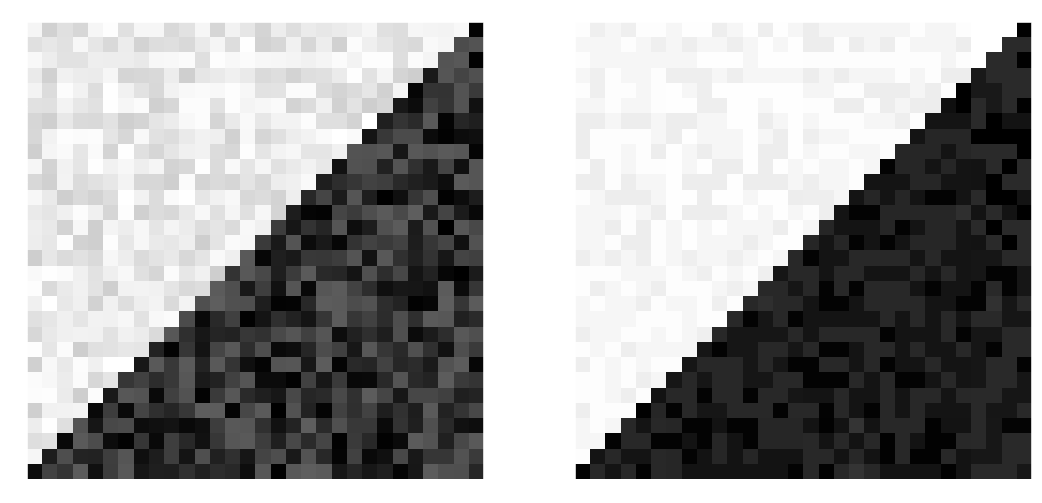

In [34]:
np.random.seed(12)
ref_img = step_image_BW(n=30)

new_img = smoothing(
    ref_img=ref_img,
    lambd=10, sigma_xy=10, sigma_l=30,
    file_name="diag"
)

Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 10/10 [00:00<00:00, 167.30it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Smoothing channels: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


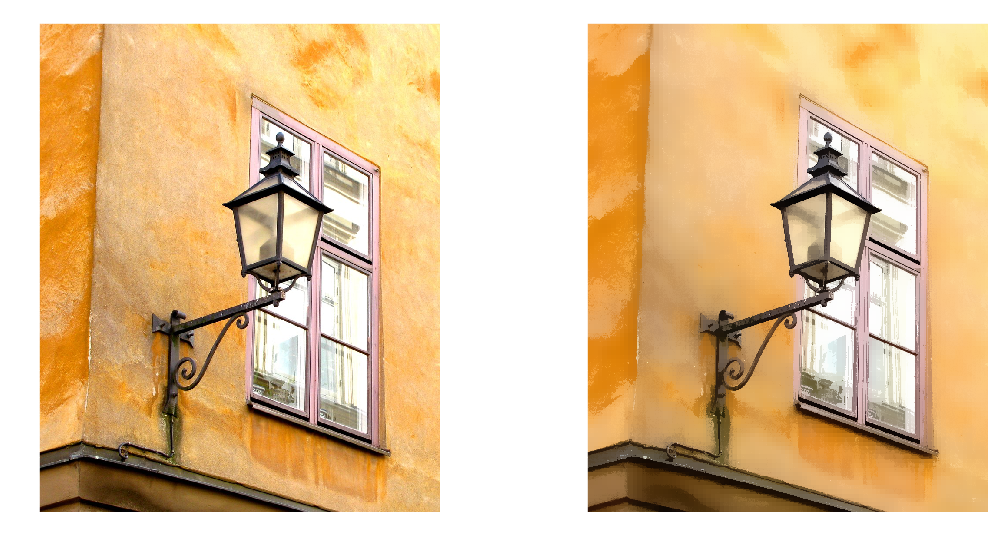

In [36]:
ref_img = (mpimg.imread("pictures/lamp.jpg")).astype(int)

new_img = smoothing(
    ref_img=ref_img,
    lambd=20, sigma_xy=10, sigma_rgb=100
)

Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 6/6 [00:00<00:00, 183.35it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Coloring UV channels: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


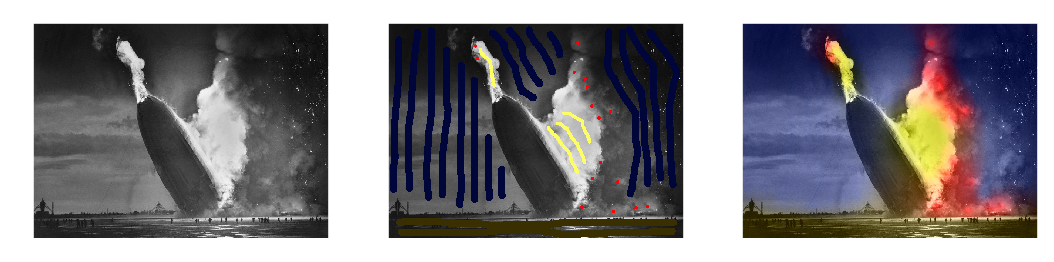

In [41]:
ref_img_BW_pil = Image.open("pictures/hindenburg_BW.jpg").convert("YCbCr")
ref_img_marked_pil = Image.open("pictures/hindenburg_marked.jpg").convert("YCbCr")
ref_img = np.asarray(ref_img_BW_pil)[:, :, :1]
target_img = np.asarray(ref_img_marked_pil)[:, :, :]

new_img = colorization(
    ref_img=ref_img, target_img=target_img,
    lambd=10, sigma_xy=5, sigma_l=60,
    file_name="BS"
)

## Domain transform

In [42]:
def box_filter_naive(I, ct, sigma_H):
    r = sigma_H * np.sqrt(3)
    J = np.empty_like(I)
    
    dim = I.shape[0]
    for p in range(dim):
        J_p = 0
        K_p = 0
        for q in range(p, dim):
            if abs(ct[q] - ct[p]) > r:
                break
            J_p += I[q, :]
            K_p += 1
        for q in range(p-1, -1):
            if abs(ct[q] - ct[p]) > r:
                break
            J_p += I[q, :]
            K_p += 1 
        J[p, :] = J_p[:] / K_p
    return J

def box_filter_recursive1(I, ct, sigma_H):
    a = np.exp(-np.sqrt(2) / sigma_H)
    dim, channels = I.shape
    
    J_tmp = np.empty_like(I)
    J_tmp[0, :] = I[0, :]
    for p in range(1, dim):
        d = ct[p] - ct[p-1]
        J_tmp[p, :] = (1 - a**d) * I[p, :] + (a**d) * J_tmp[p-1, :]
    
    J = np.empty_like(I)
    J[-1, :] = J_tmp[-1, :]
    for p in range(dim-2, -1, -1):
        d = ct[p+1] - ct[p]
        J[p, :] = (1 - a**d) * J_tmp[p, :] + (a**d) * J[p+1, :]
    
    return J

def box_filter_recursive2(I, ct, sigma_H):
    a = np.exp(-np.sqrt(2) / sigma_H) 
    d = np.diff(ct)
    J = np.empty_like(I)
    
    dim, channels = I.shape
    
    A_forward = sparse.diags([1] + list(1 - a**d))
    B_forward = sparse.identity(dim) - sparse.diags(a**d, -1)
    
    A_backward = sparse.diags(list(1 - a**d) + [1])
    B_backward = sparse.identity(dim) - sparse.diags(a**d, 1)
    
    for channel in range(channels):
        J[:, channel] = spalg.spsolve(B_forward, A_forward.dot(I[:, channel]))
        J[:, channel] = spalg.spsolve(B_backward, A_backward.dot(J[:, channel]))
    
    return J

In [43]:
def smooth_cols(I, sigma_s, sigma_r, it, I_ref=None, N_it=3):
    if I_ref is None:
        I_ref = I
    sigma_H = sigma_s * np.sqrt(3) * (2 ** (N_it - it)) / np.sqrt(4 ** N_it - 1)
    new_I = np.empty_like(I)
    I_ref_prime = np.vstack([I_ref[:1, :, :], np.diff(I_ref, axis=0)])
    for col in trange(I.shape[1], desc="Domain transform - iteration {} - columns".format(it)):
        ct = np.cumsum(1 + (sigma_s / sigma_r) * np.abs(I_ref_prime[:, col, :].sum(axis=1)))
        new_I_slice = box_filter_recursive2(I[:, col, :], ct, sigma_H)
        new_I[:, col, :] = new_I_slice
    return new_I

def smooth_rows(I, sigma_s, sigma_r, it, I_ref=None, N_it=3):
    if I_ref is None:
        I_ref = I
    sigma_H = sigma_s * np.sqrt(3) * (2 ** (N_it - it)) / np.sqrt(4 ** N_it - 1)
    new_I = np.empty_like(I)
    I_ref_prime = np.hstack([I_ref[:, :1, :], np.diff(I_ref, axis=1)])
    for row in trange(I.shape[0], desc="Domain transform - iteration {} - rows".format(it)):
        ct = np.cumsum(1 + (sigma_s / sigma_r) * np.abs(I_ref_prime[row, :, :].sum(axis=1)))
        new_I_slice = box_filter_recursive2(I[row, :, :], ct, sigma_H)
        new_I[row, :, :] = new_I_slice
    return new_I

In [44]:
def domain_transform(I0, sigma_s, sigma_r, I_ref=None, N_it=3):
    I = I0.copy()
    for it in range(1, N_it+1):
        for axis in [0, 1]:
            if axis == 1:
                I = smooth_rows(I, sigma_s, sigma_r, it, I_ref=I_ref, N_it=N_it)
            else:
                I = smooth_cols(I, sigma_s, sigma_r, it, I_ref=I_ref, N_it=N_it)
    return I

Domain transform - iteration 5 - rows: 100%|██████████| 30/30 [00:00<00:00, 696.96it/s]


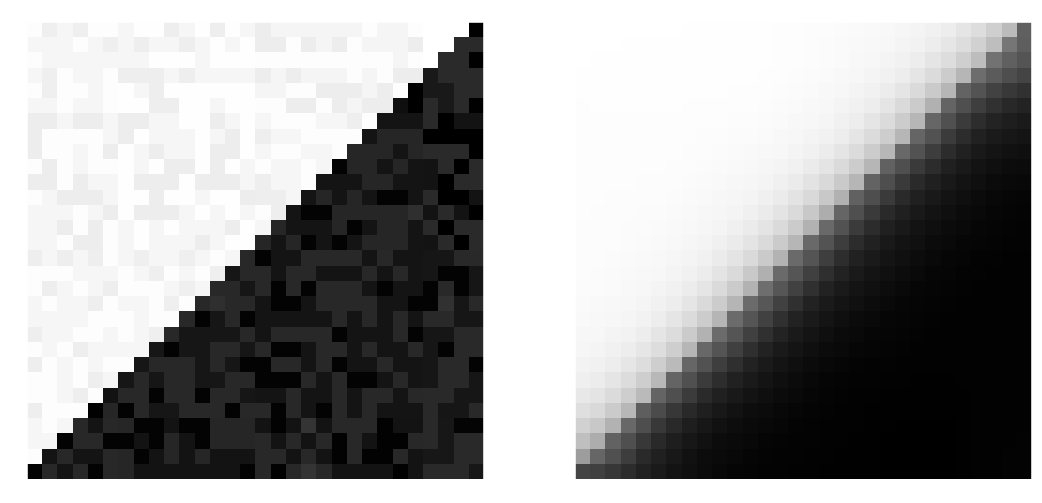

In [45]:
diag = mpimg.imread("results/smoothing_diag_new.png")[:, :, None]
diag_better = domain_transform(diag, sigma_s=5, sigma_r=1, N_it=5)
show_smoothing(diag, diag_better, file_name=None)

Domain transform - iteration 3 - rows: 100%|██████████| 583/583 [00:01<00:00, 335.54it/s]


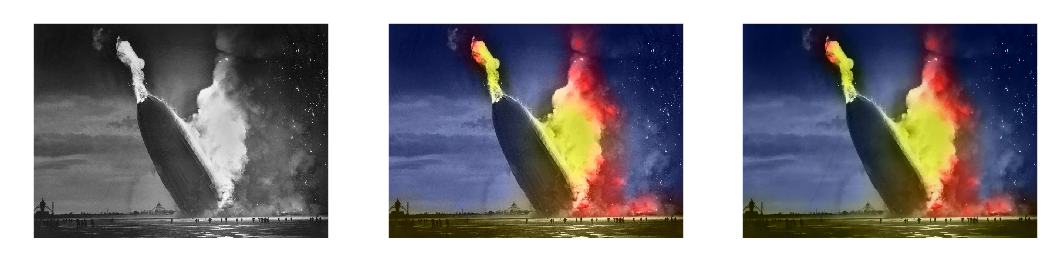

In [46]:
hind_BW = np.asarray(Image.open("pictures/hindenburg_BW.jpg").convert("YCbCr"))[:, :, :1]
hind_colorized = np.asarray(Image.open("results/colorization_BS_new.png").convert("YCbCr"))[:, :, :]
hind_better_colorized = domain_transform(hind_colorized, sigma_s=120, sigma_r=30, I_ref=hind_BW, N_it=3)

show_colorization(hind_BW, hind_colorized, hind_better_colorized, file_name="BS+DT")

## Depth superresolution

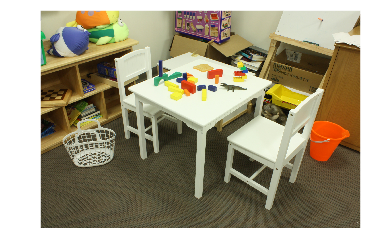

In [64]:
scene_pil = Image.open("pictures/im0.png")
plt.imshow(np.asarray(scene_pil))
plt.show()

scene = (np.asarray(scene_pil.convert("YCbCr")) * 255).astype(int)
disp = mpimg.imread("pictures/disp0.png")

f = 8
scene = scene[:f * (scene.shape[0] // f), :f * (scene.shape[1] // f)]
disp = disp[:f * (disp.shape[0] // f), :f * (disp.shape[1] // f)]

# from txt file
doffs=100.279
baseline=193.006
f1=2329.558
depth = baseline * f1 / (disp + doffs)

In [68]:
noise_level = 20

noisy_depth_downsampled = skimage.transform.resize(
    depth + np.random.normal(scale=noise_level * disp),
    output_shape=np.array(depth.shape) // f,
    mode="constant", anti_aliasing=False
)
noisy_depth_downsampled -= noisy_depth_downsampled.min()

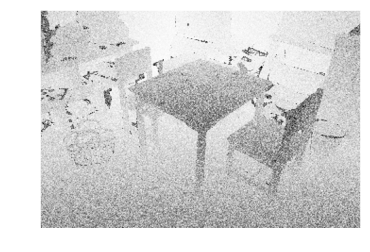

In [69]:
noisy_depth = skimage.transform.pyramid_expand(
    noisy_depth_downsampled, upscale=f,
    order=3, multichannel=False
)
plt.imshow(noisy_depth, cmap="Greys_r")

Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 10/10 [00:09<00:00,  1.62it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]


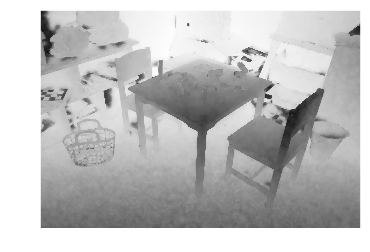

In [67]:
ref_img = scene

sigma_xy = 10
sigma_l = 10
sigma_uv = 10
sigma = np.array([sigma_xy, sigma_xy, sigma_l, sigma_uv, sigma_uv])
lambd = 5

bilateral_grid = BilateralGrid(ref_img, sigma)
S, B = bilateral_grid.S, bilateral_grid.B

target_img = noisy_depth[:, :, None]

C_block = stats.norm.pdf(
    x=np.indices((f, f))[0] + np.indices((f, f))[1],
    loc=0, scale=f/4
)
C = np.tile(C_block, (target_img.shape[0] // f, target_img.shape[1] // f)).flatten()
T = target_img.flatten()

y = solve(bilateral_grid, C, T, lambd)
x = S.T.dot(y).reshape(ref_img.shape[:2])

new_img = x[:, :, None]

plt.imshow(new_img[:, :, 0], cmap="Greys_r")